# Установка и импорт библиотек

In [2]:
#pip install AnaText==2.1.2.dev0 -q

Note: you may need to restart the kernel to use updated packages.


In [55]:
#pip install bertopic -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings
from pathlib import Path
import time

import eta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import (
    adjusted_mutual_info_score,
    adjusted_rand_score,
    silhouette_score,
)
from bertopic import BERTopic
from typing import Tuple, Dict

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score, silhouette_score, normalized_mutual_info_score

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

# Скачивание и сохранение в файл датасета 20newsgroups

In [4]:
# Загрузка датасета 20 newsgroups
newsgroups_train = fetch_20newsgroups(subset="train")

# Преобразование данных в DataFrame
newsgroups_data = {"text": newsgroups_train.data}
true_labels = newsgroups_train.target
df_newsgroups = pd.DataFrame(newsgroups_data)

# Сохранение DataFrame в CSV-файл
df_newsgroups.to_csv("newsgroups_train.csv", index=False)

# AnaText

In [5]:
def anatext_clust_with_keyw(filename):
    output_dict = eta.cluster_documents_with_keywords(filename, verbose=False)

    df = output_dict["df"]
    top_word_dict = output_dict["top_word_dict"]
    data = output_dict["data"]
    embeddings = output_dict["embeddings"]

    return top_word_dict, data

# BERTopic

In [6]:
def bertopic_clust_with_keyw(file_path: str):
    """
    Читает тексты из файла, обучает BERTopic на этих текстах,
    возвращает датафрейм и словарь топ слов.

    :param file_path: Путь к файлу CSV, содержащему тексты в колонке 'text'.
    :return: Кортеж, содержащий датафрейм с текстами, их эмбеддингами и классами, 
             а также словарь с топ словами для каждого кластера.
    """
    # Чтение файла
    df_texts = pd.read_csv(file_path)
    texts = df_texts['text'].tolist()

    # Инициализация BERTopic
    topic_model = BERTopic(embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2", calculate_probabilities=False)

    # Обучение модели и получение кластеров
    topics, _ = topic_model.fit_transform(texts)
    
    # Получение эмбеддингов
    embeddings = topic_model._extract_embeddings(texts)

    # Получение топ слов для каждого кластера
    topic_info = topic_model.get_topic_info()
    topic_words = {row['Topic']: topic_model.get_topic(row['Topic']) for index, row in topic_info.iterrows() if row['Topic'] >= 0}

    # Создание датафрейма с результатами
    df_results = pd.DataFrame({
        'text': texts,
        'embeddings': list(embeddings),
        'class': topics
    })

    return df_results, topic_words

# Оценивание результатов кластеризации

In [7]:
def evaluate_clustering_and_visualize(df, true_labels, class_column_name):
    """
    Уменьшает размерность эмбеддингов до 2, визуализирует и оценивает качество кластеризации.

    :param df: DataFrame с колонками 'embeddings' и class_column_name (имя колонки с классами).
    :param true_labels: Вектор с истинными метками для текстов.
    :param class_column_name: Имя колонки, содержащей метки классов.
    :return: DataFrame с оценками качества кластеризации и визуализация.
    """
    # Уменьшение размерности с помощью UMAP
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    embeddings_2d = umap_reducer.fit_transform(list(df["embeddings"]))

    # Добавляем результаты в датафрейм
    df["Component 1"] = embeddings_2d[:, 0]
    df["Component 2"] = embeddings_2d[:, 1]

    # Проверяем количество уникальных классов
    unique_classes = df[class_column_name].nunique()

    # Визуализация
    plt.figure(figsize=(16, 10))
    if unique_classes > 1:
        sns.scatterplot(
            x="Component 1", y="Component 2", hue=class_column_name,
            data=df, legend=None, palette=sns.color_palette("hsv", unique_classes), alpha=0.7
        )
    else:
        # Для одного класса используем один цвет
        sns.scatterplot(
            x="Component 1", y="Component 2",
            data=df, color="blue", alpha=0.7, legend=None
        )
    plt.title("2D space data visualization")
    plt.show()

    # Оценка кластеризации
    metrics = {
        "Adjusted Rand Index": round(adjusted_rand_score(true_labels, df[class_column_name]), 2),
        "Adjusted Mutual Information": round(adjusted_mutual_info_score(true_labels, df[class_column_name]), 2),
        "Homogeneity": round(homogeneity_score(true_labels, df[class_column_name]), 2),
        "Completeness": round(completeness_score(true_labels, df[class_column_name]), 2),
        "V-measure": round(v_measure_score(true_labels, df[class_column_name]), 2),
        "Normalized Mutual Information": round(normalized_mutual_info_score(true_labels, df[class_column_name]), 2)
    }

    if unique_classes > 1:
        metrics["Fowlkes-Mallows Index"] = round(fowlkes_mallows_score(true_labels, df[class_column_name]), 2)
        metrics["Silhouette Score"] = round(silhouette_score(embeddings_2d, df[class_column_name]), 2)
    else:
        print("Silhouette Score and Fowlkes-Mallows Index cannot be computed for a single class.")

    # Возвращаем результаты в виде датафрейма
    metrics_df = pd.DataFrame(list(metrics.items()), columns=["Metric", "Score"])

    return metrics_df

# Оптимальные значения метрик качества кластеризации

## Adjusted Rand Index (ARI)
- **Диапазон значений**: [-1, 1]
- **Лучшее значение**: 1
- **Интерпретация**: Значение 1 указывает на идеальное совпадение между двумя разбиениями. Значение близкое к 0 или отрицательное значение указывает на случайное (или худшее) совпадение.

## Adjusted Mutual Information (AMI)
- **Диапазон значений**: [0, 1]
- **Лучшее значение**: 1
- **Интерпретация**: Значение 1 указывает на идеальное совпадение. Значение близкое к 0 указывает на отсутствие информационного совпадения между разбиениями.

## Homogeneity
- **Диапазон значений**: [0, 1]
- **Лучшее значение**: 1
- **Интерпретация**: Значение 1 указывает, что все кластеры содержат только членов одного и того же класса.

## Completeness
- **Диапазон значений**: [0, 1]
- **Лучшее значение**: 1
- **Интерпретация**: Значение 1 указывает, что все члены одного класса присутствуют в одном и том же кластере.

## V-measure
- **Диапазон значений**: [0, 1]
- **Лучшее значение**: 1
- **Интерпретация**: Значение 1 указывает на совершенный баланс между однородностью и полнотой.

## Normalized Mutual Information (NMI)
- **Диапазон значений**: [0, 1]
- **Лучшее значение**: 1
- **Интерпретация**: Значение 1 указывает на идеальное совпадение между разбиениями.

## Silhouette Score
- **Диапазон значений**: [-1, 1]
- **Лучшее значение**: 1
- **Интерпретация**: Значение близкое к 1 указывает, что объекты хорошо сгруппированы и четко отделены друг от друга. Значение близкое к 0 указывает на перекрывающиеся кластеры. Отрицательные значения указывают на то, что объекты могли быть отнесены к неправильным кластерам.

## Fowlkes-Mallows Index
- **Диапазон значений**: [0, 1]
- **Лучшее значение**: 1
- **Интерпретация**: Значение 1 указывает на идеальное согласование между предсказанными и истинными метками.

# Построение таблицы ключевых слов по словарям

In [8]:
def build_dataframe_from_keyw_dict(clusters):
    '''
    Создает DataFrame из словаря кластеров с ключевыми словами.
    Каждый кластер представлен строкой в DataFrame, а ключевые слова размещены в столбцах.
    Кластеры упорядочены по убыванию их номеров, а для столбцов установлены названия "Keyword 1", "Keyword 2", ..., "Keyword N".
    
    Parameters:
    - clusters (dict): Словарь кластеров, где ключи - это номера кластеров, а значения - списки ключевых слов.
    
    Returns:
    - pandas.DataFrame: DataFrame, где каждая строка соответствует кластеру, а столбцы содержат ключевые слова.
    '''
    # Сортировка ключей словаря по убыванию для упорядочивания кластеров
    sorted_clusters_keys = sorted(clusters.keys(), reverse=True)
    # Создание списка списков ключевых слов для каждого кластера
    data = [clusters[key] for key in sorted_clusters_keys]
    # Определение названий колонок
    column_names = [f"Keyword {i+1}" for i in range(len(data[0]))]
    # Создание DataFrame из отсортированных данных с названиями колонок
    df = pd.DataFrame(data, index=sorted_clusters_keys, columns=column_names)
    return df

# Тестирование AnaText

In [13]:
start_time_anatext = time.time()

anatext_top_word_dict, anatext_data = anatext_clust_with_keyw("newsgroups_train.csv")

end_time_anatext = time.time()
execution_time_anatext = end_time_anatext - start_time_anatext

In [22]:
print(f"Время выполнения функции: {round(execution_time_anatext, 2)} секунд.")

Время выполнения функции: 840.48 секунд.


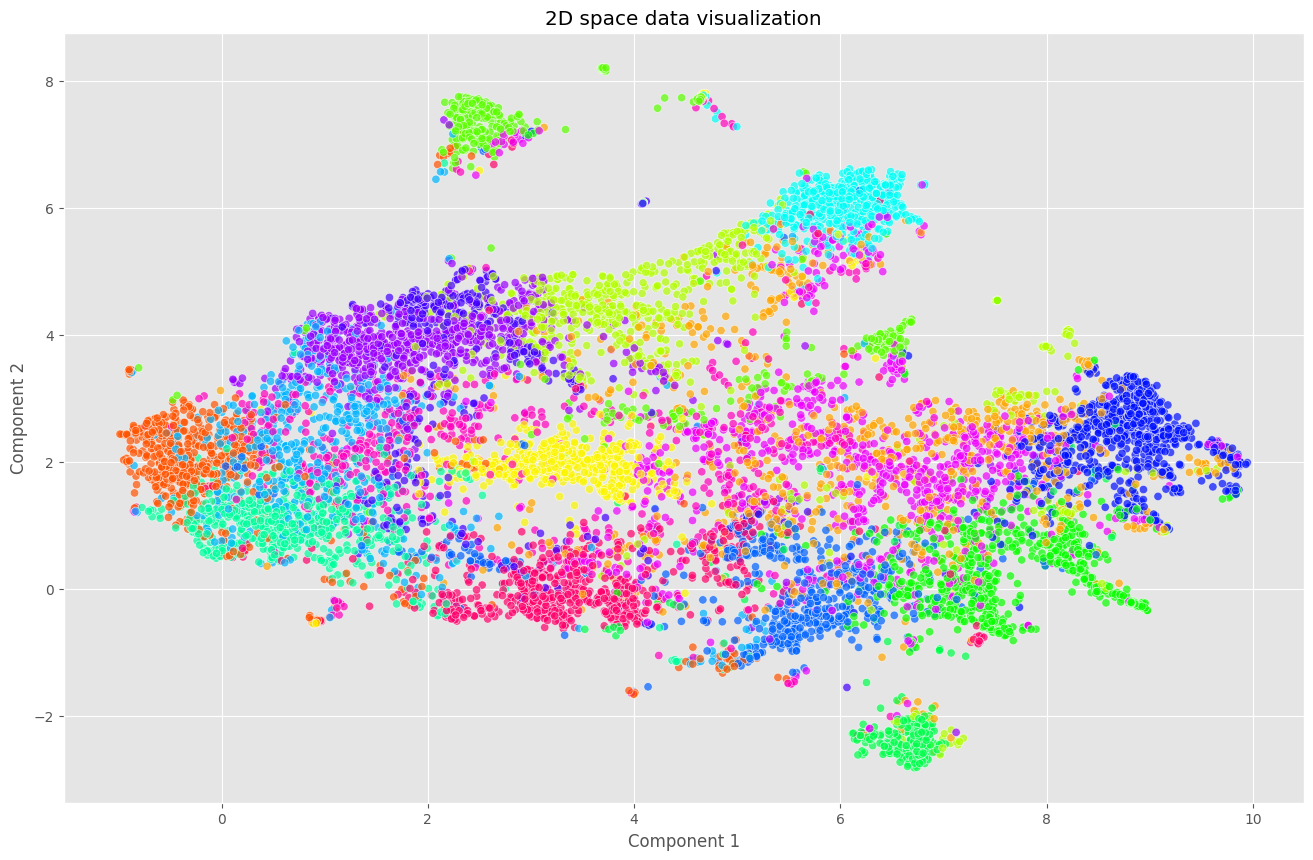

,Metric,Score
0,Adjusted Rand Index,0.15
1,Adjusted Mutual Information,0.31
2,Homogeneity,0.30
3,Completeness,0.32
4,V-measure,0.31
5,Normalized Mutual Information,0.31
6,Fowlkes-Mallows Index,0.20
7,Silhouette Score,0.08


In [15]:
evaluate_clustering_and_visualize(anatext_data, true_labels, "current_class")

In [16]:
build_dataframe_from_keyw_dict(anatext_top_word_dict)

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5,Keyword 6,Keyword 7,Keyword 8,Keyword 9,Keyword 10
16,engine,car,bike,drive,motorcycle,speed,driver,back,slow,gas
15,fax,mail,post,file,host,usenet,sale,ftp,orbit,address
14,oh,back,god,cc,get,post,bmw,hmmm,freenet,newsgroup
13,window,post,card,host,help,organization,nntp,computer,problem,question
12,sale,interested,buy,offer,price,bike,cheap,sell,card,cost
11,god,atheist,bible,faith,morality,islam,heaven,gay,christianity,christians
10,government,encryption,key,chip,tax,phone,pay,federal,moon,cost
9,window,problem,card,help,use,apple,mac,software,computer,disk
8,team,hockey,game,baseball,league,player,win,coach,toronto,goal
7,disk,motherboard,computer,chip,monitor,hardware,controller,problem,fast,modem


# Тестирование BERTopic

In [18]:
start_time_bertopic = time.time()

bertopic_data, bertopic_top_word_dict = bertopic_clust_with_keyw("newsgroups_train.csv")

end_time_bertopic = time.time()
execution_time_bertopic = end_time_bertopic - start_time_bertopic

In [19]:
print(f"Время выполнения функции: {round(execution_time_bertopic, 2)} секунд.")

Время выполнения функции: 326.84 секунд.


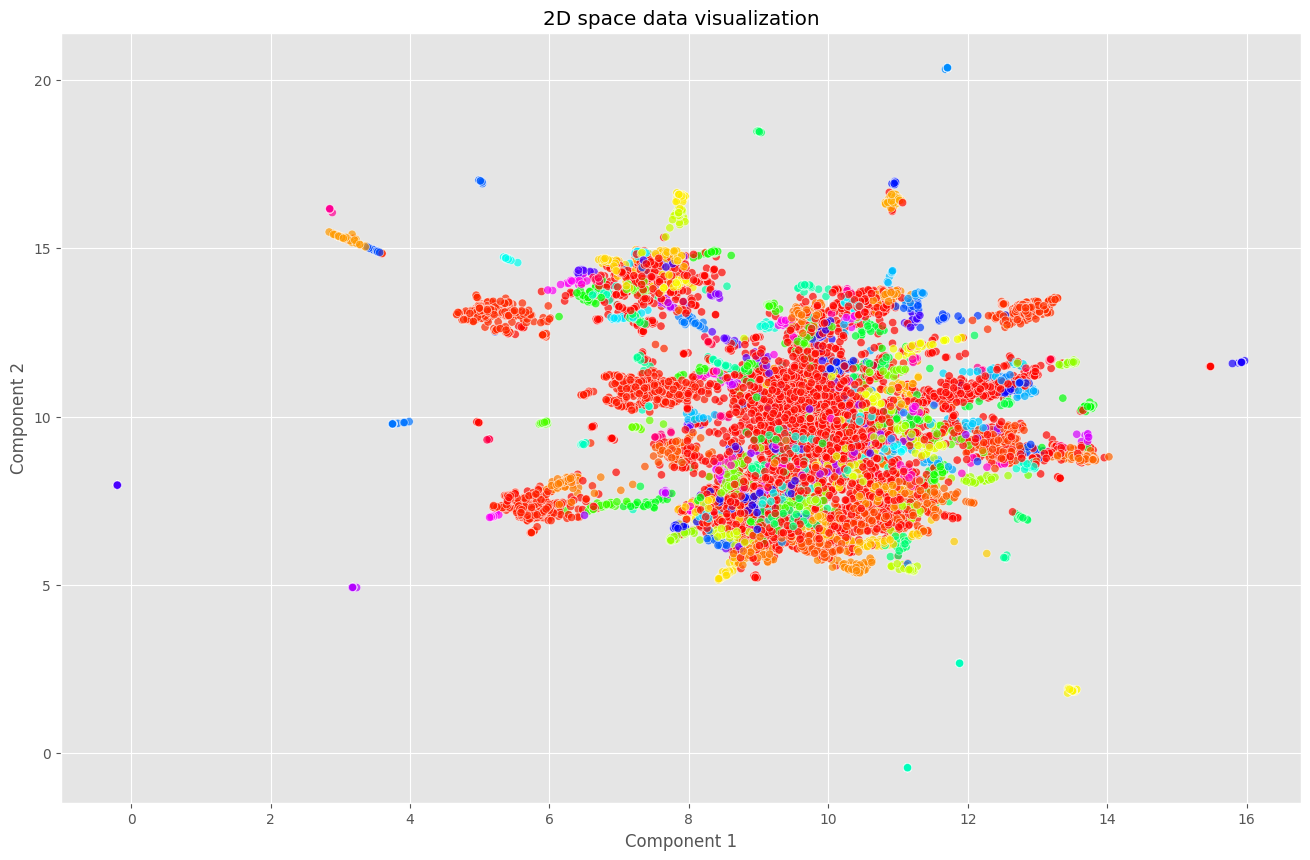

,Metric,Score
0,Adjusted Rand Index,0.06
1,Adjusted Mutual Information,0.40
2,Homogeneity,0.48
3,Completeness,0.38
4,V-measure,0.42
5,Normalized Mutual Information,0.42
6,Fowlkes-Mallows Index,0.14
7,Silhouette Score,-0.18


In [20]:
evaluate_clustering_and_visualize(bertopic_data, true_labels, "class")

In [21]:
build_dataframe_from_keyw_dict(bertopic_top_word_dict)

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5,Keyword 6,Keyword 7,Keyword 8,Keyword 9,Keyword 10
172,"(cf, 0.041679040560197333)","(god, 0.03064721550969464)","(bible, 0.02741980121646582)","(salvation, 0.023044270850499777)","(gospels, 0.020183107746999093)","(godhead, 0.018364717454932716)","(translations, 0.016630013525828793)","(essene, 0.016570483040447136)","(scripture, 0.014771531192285093)","(whoah, 0.013614335768507577)"
171,"(sky, 0.04205121220663276)","(enzo, 0.03635541236416089)","(canon, 0.024102215435161674)","(oz, 0.01892124639313962)","(space, 0.0186099000124979)","(liguori, 0.01758743048529267)","(pollution, 0.017393392486325716)","(research, 0.016462836383662152)","(vandalizing, 0.016145938681337263)","(night, 0.016121667503224187)"
170,"(ke4zv, 0.0589225156903273)","(moon, 0.048325488591045226)","(gary, 0.04647225982959671)","(luna, 0.0315339329476099)","(base, 0.02961397165714063)","(lunar, 0.029539230290951613)","(coffman, 0.02946780412357347)","(qucdn, 0.026076987186266175)","(queensu, 0.025258117820205834)","(uucp, 0.01875516855763403)"
169,"(hulman, 0.09826507781849181)","(rickert, 0.09358960927142783)","(rose, 0.08046080472478845)","(nextwork, 0.07899913931654433)","(babylon, 0.02629797274141348)","(yankees, 0.02126975478036604)","(john, 0.019916417561619514)","(nameserver, 0.019659715443399946)","(g215a, 0.019659715443399946)","(braves, 0.016591172606778722)"
168,"(lunar, 0.05488301383297984)","(moon, 0.03751797039684055)","(manned, 0.03579534406435007)","(crystal, 0.028752271418824547)","(orbit, 0.025099627317925862)","(exploration, 0.024662833476086447)","(henry, 0.022906160561171823)","(crash, 0.021368138311062816)","(aiaa, 0.0195705840646106)","(conference, 0.01936763795454692)"
...,...,...,...,...,...,...,...,...,...,...
4,"(gun, 0.021284746349214016)","(guns, 0.011817934566097161)","(firearms, 0.007413893486263947)","(weapons, 0.006980114289939322)","(militia, 0.006891327623365945)","(you, 0.006683771843371594)","(weapon, 0.00628802805527499)","(of, 0.006234805266738947)","(to, 0.005947220473393264)","(the, 0.005900567048271358)"
3,"(israel, 0.01961361208507897)","(israeli, 0.017619005598769832)","(jews, 0.013348440322035266)","(arab, 0.009029575186769221)","(jewish, 0.007095688257320499)","(of, 0.007063822111554469)","(the, 0.0069735700599597465)","(arabs, 0.006430357372342816)","(in, 0.006266088890590686)","(not, 0.0062474019281753175)"
2,"(encryption, 0.01842573883404759)","(key, 0.01682525512248558)","(clipper, 0.01616624154071739)","(chip, 0.014063827224754967)","(escrow, 0.009294937535764573)","(keys, 0.008342412213325845)","(security, 0.008093061581020558)","(government, 0.007310816874163304)","(crypto, 0.007239585270654543)","(algorithm, 0.007152418350638109)"
1,"(pitt, 0.011629413879936887)","(geb, 0.01093682204668203)","(gordon, 0.01079914974882513)","(banks, 0.010668979874206697)","(disease, 0.00694049356195845)","(doctor, 0.006931188598784619)","(patients, 0.006663493144251634)","(is, 0.006512534563987375)","(it, 0.006257055941408017)","(pain, 0.005987190035442383)"
